### Parameters

In [39]:
# feature column
features_colname = ['prev_CW/SA_rate', 'U_create2now', 'U_approve2now','prev_CW x SA_rate', 'type_RN', 
'type_LVN+LPN', 'segmentName_d', 'areaName_houston', 'areaName_no', 'areaName_dfw', 
'areaName_austin', 'areaName_san', 'net_pay', 'CW_in_a_month', 'count_prev_SA', 
'count_prev_CW']
# , 'high_ucw_facilitites', 'low_ucw_facilitites', 'days_of_week', 'sunday_or_not', 'Start_time_of_the_day'

end_of_week = '2021-4-14'

### Logistic Regression Body(preprocessing - classification report)

In [40]:
###################
### import data ###
###################
import pandas as pd
import numpy as np
df = pd.read_csv('model_data.csv').drop(columns = ['Unnamed: 0'])
# some values are nan, mark it as -1
df['U_approve2now'] = df['U_approve2now'].fillna(-1)


######################
### data prepration###
######################

## output: applications after today
# # Slice df by the end of this week, for predcition output
# end_of_week = '2021-4-14'
# convert to datetime for conditonal selection
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
# sort by start time -> for slicing
df = df.sort_values(by = 'Start_Time') 
# record as realdata
realdata = df[df['Start_Time'].apply(lambda x: x > pd.to_datetime(end_of_week))]
# record predction output rows, don't include it in tran test validation
realdata_len = realdata.shape[0]
# only keep status = confirmed
realdata = realdata[realdata['status'] == 'confirmed']

## Validation set: 1000 recently records
# slice, dont include realdata
validation = df[-1000-realdata_len : -realdata_len] # slice
y_valid = validation['target'] # prep y
x_valid = validation[features_colname] # prep x

## Train test: main dataset - validation set - output(realdata) set
traintest = df[:-1000-realdata_len] # slice 
X = traintest[features_colname] # prep x
y = traintest['target'] # prep y
# set test, train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


###################
### train logit ###
###################
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# assign less punlishment for classifying 0 as 1 -> find more 1's
weights = {0:1, 1:10}
# class_weight = 'balanced': automatically adjust weights inversely proportional to class frequencies in the input data
logit = LogisticRegression(solver = 'lbfgs', max_iter=100000, class_weight = weights)
logit.fit(X_train, y_train)


#############
# Threshold #
#############
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
# predict probabilities
yhat = logit.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test,yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
lower_limiter = thresholds[ix]

# search thresholds for imbalanced classification
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
# predict probabilities
yhat = logit.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
higher_limiter = thresholds[ix]


#########################
### train test result ###
#########################
from sklearn.metrics import classification_report, confusion_matrix
y_pred = logit.predict(X_test)
Traintest_CM = confusion_matrix(y_test, y_pred)
Traintest_CR = classification_report(y_test, y_pred)

# overfit
y_pred = logit.predict(X_train)
overfit_CM = confusion_matrix(y_train, y_pred)
overfit_CR = classification_report(y_train, y_pred)

# logit summary
import statsmodels.api as sm
smlogit = sm.Logit(y_train, X_train).fit()
logit_summary = smlogit.summary()


#########################
### validation result ###
#########################
# lower threshold
limiter = lower_limiter
y_prob = list(logit.predict_proba(x_valid)[:,1])
y_pred = []
count =0
for prob in y_prob:
    if prob >= limiter:
        y_pred.append(1)
        count+=1
    else:
        y_pred.append(0)
low_vad_CM = confusion_matrix(y_valid, y_pred)
low_vad_CR = classification_report(y_valid, y_pred)
Dict_low_vad_CR = classification_report(y_valid, y_pred, output_dict=True)

# high threshold
limiter = higher_limiter
y_prob = list(logit.predict_proba(x_valid)[:,1])
y_pred = []
count =0
for prob in y_prob:
    if prob >= limiter:
        y_pred.append(1)
        count+=1
    else:
        y_pred.append(0)
high_vad_CM = confusion_matrix(y_valid, y_pred)
high_vad_CR = classification_report(y_valid, y_pred)
Dict_high_vad_CR = classification_report(y_valid, y_pred, output_dict=True)

########################
### excutive summary ###
########################
from sklearn.metrics import recall_score
label_coverage = y_pred.count(1)/len(y_pred)
UCW_coverage = recall_score(y_valid, y_pred)
Excutive_Summary = 'The limiter we adopt is %.2f' % (limiter) + '. ' + 'By covering %.3f labeled as high probability of UCW, we have prepared for %.3f of real UCW' % (label_coverage,UCW_coverage)


########################
### output prediction ##
########################
# return lower_limiter, higher_limiter, Traintest_CM, Traintest_CR, overfit_CM, overfit_CR, 
# low_vad_CM, low_vad_CR, low_vad_CR, low_vad_CR, logit_summary, logit, Excutive_Summary



Optimization terminated successfully.
         Current function value: 0.232856
         Iterations 8


### Logistic Regression Summary

In [41]:
print(logit_summary)

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                45344
Model:                          Logit   Df Residuals:                    45328
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 Apr 2021   Pseudo R-squ.:                 0.06480
Time:                        20:31:44   Log-Likelihood:                -10559.
converged:                       True   LL-Null:                       -11290.
Covariance Type:            nonrobust   LLR p-value:                4.372e-303
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
prev_CW/SA_rate       2.2580      0.265      8.535      0.000       1.739       2.777
U_create2now         -0.0100      0.007     -1.515      0.130      -0.023       0.003
U_approve2now        -0.

## Classification Report

### Train Test

In [42]:
print(Traintest_CM)
print('\n')
print(Traintest_CR)

[[14413  3721]
 [  670   630]]


              precision    recall  f1-score   support

           0       0.96      0.79      0.87     18134
           1       0.14      0.48      0.22      1300

    accuracy                           0.77     19434
   macro avg       0.55      0.64      0.55     19434
weighted avg       0.90      0.77      0.82     19434



### Overfit

In [43]:
print(overfit_CM)
print('\n')
print(overfit_CR)

[[33528  8723]
 [ 1588  1505]]


              precision    recall  f1-score   support

           0       0.95      0.79      0.87     42251
           1       0.15      0.49      0.23      3093

    accuracy                           0.77     45344
   macro avg       0.55      0.64      0.55     45344
weighted avg       0.90      0.77      0.82     45344



### Validation
#### <font color = Blue> Lower

In [44]:
print('Applying lower(for Recall) threshhold of {}'.format(lower_limiter))
print('\n')
print(low_vad_CM)
print('\n')
print(low_vad_CR)

Applying lower(for Recall) threshhold of 0.4419578428184474


[[416 489]
 [ 16  79]]


              precision    recall  f1-score   support

           0       0.96      0.46      0.62       905
           1       0.14      0.83      0.24        95

    accuracy                           0.49      1000
   macro avg       0.55      0.65      0.43      1000
weighted avg       0.88      0.49      0.59      1000



#### <font color = Blue> Higher

In [45]:
print('Applying higher(for precision) threshhold of {}'.format(higher_limiter))
print('\n')
print(high_vad_CM)
print('\n')
print(high_vad_CR)

Applying higher(for precision) threshhold of 0.5660000000000001


[[700 205]
 [ 41  54]]


              precision    recall  f1-score   support

           0       0.94      0.77      0.85       905
           1       0.21      0.57      0.31        95

    accuracy                           0.75      1000
   macro avg       0.58      0.67      0.58      1000
weighted avg       0.87      0.75      0.80      1000



### Excutive Summary

In [101]:
high_label_coverage = (high_vad_CM[0][1]+high_vad_CM[1][1])/1000
high_UCW_coverage = Dict_high_vad_CR['1']['recall']
low_label_coverage = (low_vad_CM[0][1]+high_vad_CM[1][1])/1000
low_UCW_coverage = Dict_low_vad_CR['1']['recall']

print('By setting limiter to %.3f' % (lower_limiter) + '. ' 
      +'We Can prepare for {:.2%} of real UCW, by marking {:.2%} labeled as high probability of UCW。'.format(low_UCW_coverage, low_label_coverage))
print('\n')
print('By setting limiter to %.3f' % (higher_limiter) + '. ' 
      +'We Can prepare for {:.2%} of real UCW, by marking {:.2%} labeled as high probability of UCW。'.format(high_UCW_coverage, high_label_coverage))


By setting limiter to 0.442. We Can prepare for 83.16% of real UCW, by marking 54.30% labeled as high probability of UCW。


By setting limiter to 0.566. We Can prepare for 56.84% of real UCW, by marking 25.90% labeled as high probability of UCW。


### CM

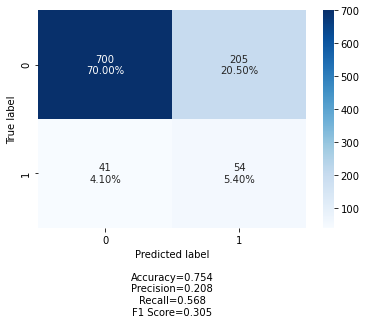

In [70]:
import cf_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
cf_matrix.make_confusion_matrix(confusion_matrix(y_valid, y_pred), group_names=labels,categories=categories)

# Fit real data in this model

In [32]:
# set input
real_X = realdata.drop(['id','user_id', 'shift_id', 'status', 'target', 'sa_create', 'Start_Time'], axis = 1)

In [33]:
X.columns

Index(['prev_CW/SA_rate', 'U_create2now', 'U_approve2now', 'prev_CW x SA_rate',
       'type_RN', 'type_LVN+LPN', 'segmentName_d', 'areaName_houston',
       'areaName_no', 'areaName_dfw', 'areaName_austin', 'areaName_san',
       'net_pay', 'CW_in_a_month', 'count_prev_SA', 'count_prev_CW'],
      dtype='object')

In [34]:
real_X.columns

Index(['prev_CW/SA_rate', 'S_create2SA_Create', 'S_Create2Start_Time',
       'SA_Create2Start_Time', 'U_create2now', 'U_approve2now',
       'prev_CW x SA_rate', 'type_RN', 'type_LVN+LPN', 'segmentName_d',
       'areaName_houston', 'areaName_no', 'areaName_dfw', 'areaName_austin',
       'areaName_san', 'net_pay', 'CW_in_a_month', 'count_prev_SA',
       'count_prev_CW', 'high_ucw_facilitites', 'reliabilityRating',
       'low_ucw_facilitites', 'days_of_week', 'sunday_or_not',
       'Start_time_of_the_day'],
      dtype='object')

In [35]:
# concat predicted prob with data
realdata['prob'] = list(logit.predict_proba(real_X)[:,1])

ValueError: could not convert string to float: 'Excellent'

In [ ]:
# record when this prediction is ran
from datetime import date
time = str(date.today().year) + '-' + str(date.today().month) + '-' + str(date.today().day)

realdata[['id', 'Start_Time', 'prob']].to_csv('pred_{}_Golden_Bullet.csv'.format(time), index = False)

In [ ]:
# to make the prediction doesn't include today
realdata['Start_Time']